In [2]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import pickle
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
# Cell 1: Authenticate and Initialize GEE
try:
    ee.Initialize()
    print("GEE initialized successfully.")
except ee.EEException as e:
    if "incompatible OAuth2 Client configuration" in str(e):
        print("""
        Error: Incompatible OAuth2 Client configuration. Please follow these steps:
        1. Go to Google Cloud Console (https://console.cloud.google.com).
        2. Verify your project has the Earth Engine API enabled (APIs & Services > Library).
        3. Check OAuth 2.0 Client ID (APIs & Services > Credentials):
           - Ensure a Web application or Desktop app client exists.
           - Add redirect URI (e.g., http://localhost:8080) if needed.
        4. Configure OAuth consent screen (APIs & Services > OAuth consent screen).
        5. Alternatively, create a new project and register it at https://signup.earthengine.google.com.
        6. Clear old tokens: Run `earthengine authenticate --clear` in terminal.
        7. Re-authenticate below.
        See https://developers.google.com/earth-engine/guides/auth#troubleshooting for details.
        """)
    print("""
    Authenticating GEE...
    1. Open the URL provided in a browser.
    2. Sign in with your GEE-registered Google account.
    3. Approve permissions to generate an authorization code.
    4. Copy the code and paste it into the input box below.
    If no input box appears, restart the kernel and re-run this cell.
    """)
    ee.Authenticate()
    try:
        ee.Initialize()
        print("GEE initialized after authentication.")
    except Exception as e2:
        print(f"Initialization failed: {e2}")
        print("Please check your Google Cloud project configuration or try a different project.")
        print("Run `earthengine authenticate --clear` in terminal to clear old tokens and retry.")

GEE initialized successfully.


In [4]:
# Cell 2: Define Region and Time Period
roi = ee.Geometry.Rectangle([26, 35, 45, 42])  # Turkey bounding box
start_date = '2019-01-01'
end_date = '2020-09-30'  # 21 months


In [5]:
# Cell 3: Fetch GEE Datasets
# Sentinel-5P: NO2, SO2, O3, CO
no2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(start_date, end_date).filterBounds(roi).select('NO2_column_number_density')
so2 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_SO2').filterDate(start_date, end_date).filterBounds(roi).select('SO2_column_number_density')
o3 = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_O3').filterDate(start_date, end_date).filterBounds(roi).select('O3_column_number_density')
co = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_CO').filterDate(start_date, end_date).filterBounds(roi).select('CO_column_number_density')
# MODIS: AOD
aod = ee.ImageCollection('MODIS/006/MCD19A2_GRANULES').filterDate(start_date, end_date).filterBounds(roi).select('Optical_Depth_047')

C:\Users\muhda\AppData\Local\Programs\Python\Python312\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD19A2_GRANULES! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD19A2_GRANULES

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
# Cell 4: Aggregate Data to Monthly Means
def aggregate_monthly(collection, band):
    months = ee.List.sequence(1, 21)  # Jan 2019 to Sep 2020
    def month_mean(m):
        start = ee.Date('2019-01-01').advance(ee.Number(m).subtract(1), 'month')
        end = start.advance(1, 'month')
        monthly_collection = collection.filterDate(start, end)
        # Check if collection has images
        count = monthly_collection.size()
        # Create a valid month string
        month_str = start.format('YYYY-MM')
        # If no images, create a zero-filled image with valid metadata
        mean = ee.Image(0).rename(band).set('month', month_str)
        # If images exist, compute mean and unmask with 0
        mean = mean.where(
            count.gt(0),
            monthly_collection.mean().select(band).unmask(0)
        )
        return mean.set('month', month_str)
    return ee.ImageCollection.fromImages(months.map(month_mean))

no2_monthly = aggregate_monthly(no2, 'NO2_column_number_density')
so2_monthly = aggregate_monthly(so2, 'SO2_column_number_density')
o3_monthly = aggregate_monthly(o3, 'O3_column_number_density')
co_monthly = aggregate_monthly(co, 'CO_column_number_density')
aod_monthly = aggregate_monthly(aod, 'Optical_Depth_047')

In [7]:
# Cell 5: Extract Data to Pandas DataFrame
def image_to_df(collection, band_name, scale=50000, max_attempts=3, delay=10):
    data = []
    print(f"Processing {band_name}...")
    # Log collection size for debugging
    collection_size = collection.size().getInfo()
    print(f"Collection size for {band_name}: {collection_size} images")
    for i in range(21):
        attempt = 0
        while attempt < max_attempts:
            try:
                img = ee.Image(collection.toList(21).get(i))
                # Fetch month property safely
                month = img.get('month').getInfo()
                if not month:
                    print(f"Warning: Month property missing for month {i+1} in {band_name}. Appending NaN.")
                    data.append({'month': None, band_name: np.nan})
                    break
                # Check if band exists
                bands = img.bandNames().getInfo()
                if band_name not in bands:
                    print(f"Warning: Band {band_name} not found in month {month}. Appending NaN.")
                    data.append({'month': month, band_name: np.nan})
                    break
                values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=scale).get(band_name).getInfo()
                data.append({'month': month, band_name: values if values is not None else np.nan})
                print(f"Processed month {month}")
                break
            except ee.EEException as e:
                attempt += 1
                if attempt == max_attempts:
                    print(f"Error processing month {i+1} for {band_name} after {max_attempts} attempts: {e}")
                    data.append({'month': None, band_name: np.nan})
                else:
                    print(f"Retrying month {i+1} for {band_name} (attempt {attempt+1}/{max_attempts})...")
                    time.sleep(delay)
            except Exception as e:
                print(f"Unexpected error in month {i+1} for {band_name}: {e}")
                data.append({'month': None, band_name: np.nan})
                break
    df = pd.DataFrame(data)
    valid_count = df[band_name].notna().sum()
    print(f"Completed {band_name}: {valid_count}/21 months with valid data")
    return df

# Process datasets sequentially with delay to avoid quota limits
datasets = [
    (no2_monthly, 'NO2_column_number_density'),
    (so2_monthly, 'SO2_column_number_density'),
    (o3_monthly, 'O3_column_number_density'),
    (co_monthly, 'CO_column_number_density'),
    (aod_monthly, 'Optical_Depth_047')
]

dataframes = []
for collection, band_name in datasets:
    df = image_to_df(collection, band_name)
    if df.empty or df[band_name].isna().all():
        print(f"Warning: No valid data for {band_name}. Check dataset availability.")
    dataframes.append(df)
    time.sleep(2)

# Merge DataFrames
df = dataframes[0]
for df_next in dataframes[1:]:
    df = df.merge(df_next, on='month', how='outer')
df['month'] = pd.to_datetime(df['month'], errors='coerce')

# Validate merged DataFrame
if df.empty or df.drop(columns='month').isna().all().all():
    print("Error: Merged DataFrame is empty or contains only NaN values. Check GEE data availability.")
else:
    print("Merged DataFrame successfully created.")

# Save merged DataFrame
with open('gee_data.pkl', 'wb') as f:
    pickle.dump(df, f)

Processing NO2_column_number_density...
Collection size for NO2_column_number_density: 21 images
Processed month 2019-01
Processed month 2019-02
Processed month 2019-03
Processed month 2019-04
Processed month 2019-05
Processed month 2019-06
Processed month 2019-07
Processed month 2019-08
Processed month 2019-09
Processed month 2019-10
Processed month 2019-11
Processed month 2019-12
Processed month 2020-01
Processed month 2020-02
Processed month 2020-03
Processed month 2020-04
Processed month 2020-05
Processed month 2020-06
Processed month 2020-07
Processed month 2020-08
Processed month 2020-09
Completed NO2_column_number_density: 21/21 months with valid data
Processing SO2_column_number_density...
Collection size for SO2_column_number_density: 21 images
Processed month 2019-01
Processed month 2019-02
Processed month 2019-03
Processed month 2019-04
Processed month 2019-05
Processed month 2019-06
Processed month 2019-07
Processed month 2019-08
Processed month 2019-09
Processed month 2019

In [8]:
# Cell 6: EDA - Summary Statistics
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   month                      21 non-null     datetime64[ns]
 1   NO2_column_number_density  21 non-null     float64       
 2   SO2_column_number_density  21 non-null     float64       
 3   O3_column_number_density   21 non-null     float64       
 4   CO_column_number_density   21 non-null     float64       
 5   Optical_Depth_047          21 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.1 KB
None

Summary Statistics:
                     month  NO2_column_number_density  \
count                   21                  21.000000   
mean   2019-10-31 16:00:00                   0.000071   
min    2019-01-01 00:00:00                   0.000061   
25%    2019-06-01 00:00:00                   0.000067   
50%    201

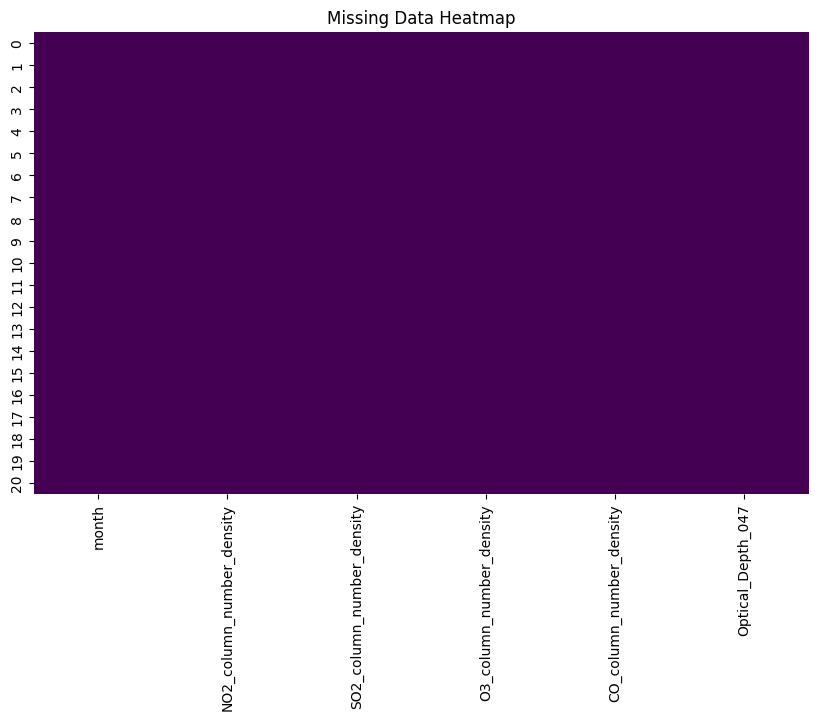

In [9]:
# Cell 7: EDA - Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.savefig('missing_data_heatmap.png')
plt.show()

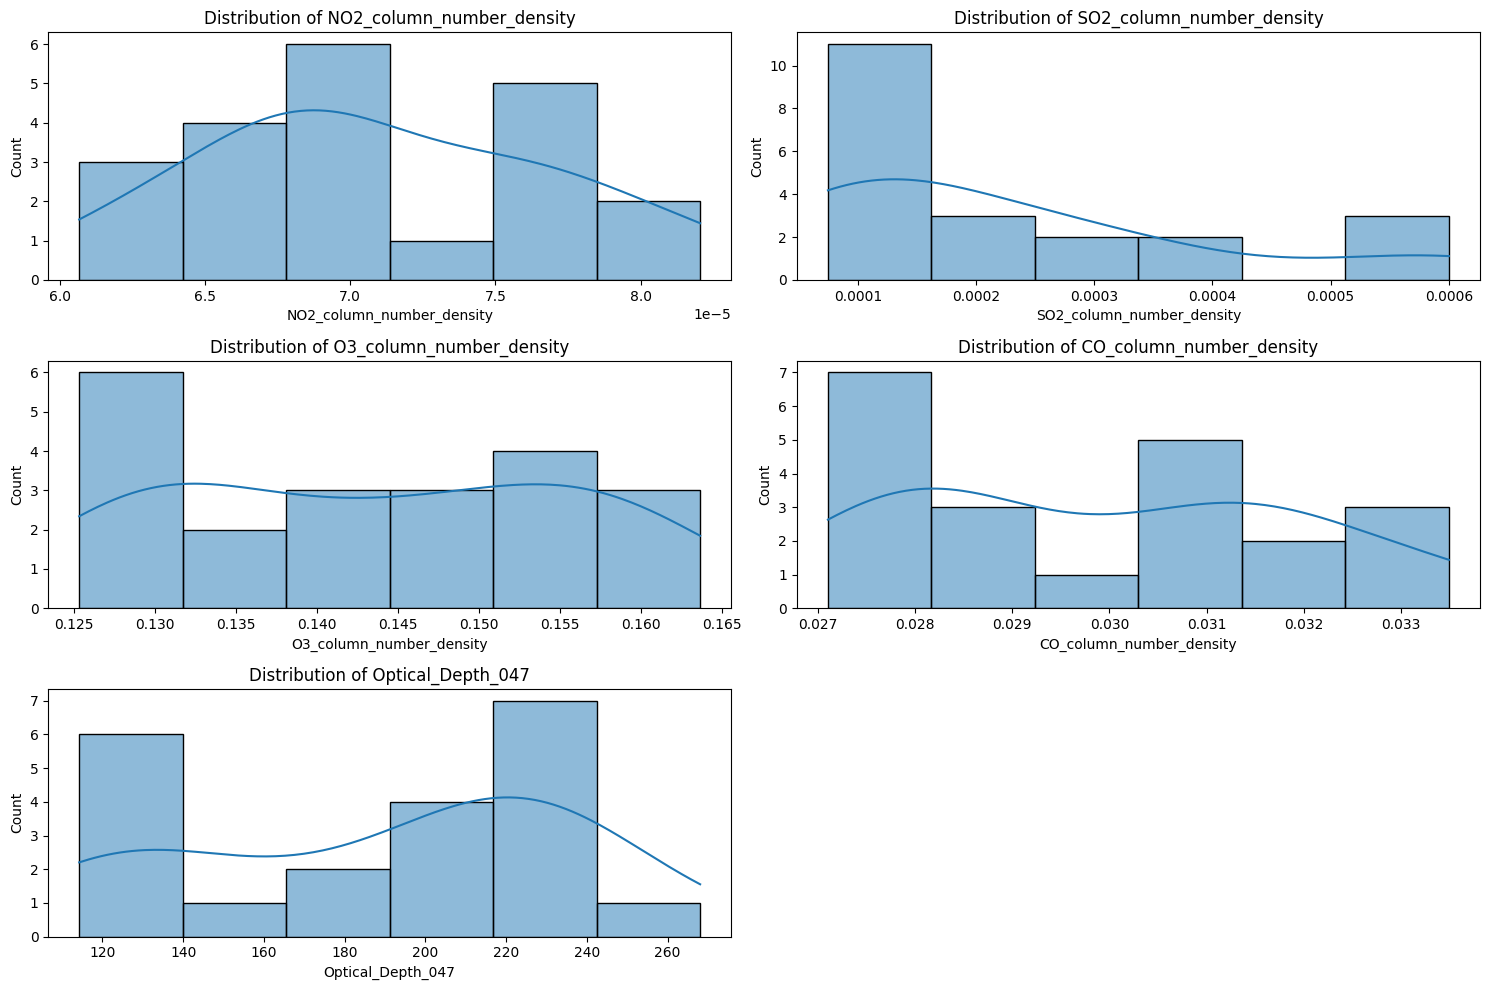

In [10]:
# Cell 8: EDA - Distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(['NO2_column_number_density', 'SO2_column_number_density', 'O3_column_number_density', 'CO_column_number_density', 'Optical_Depth_047']):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('distributions.png')
plt.show()

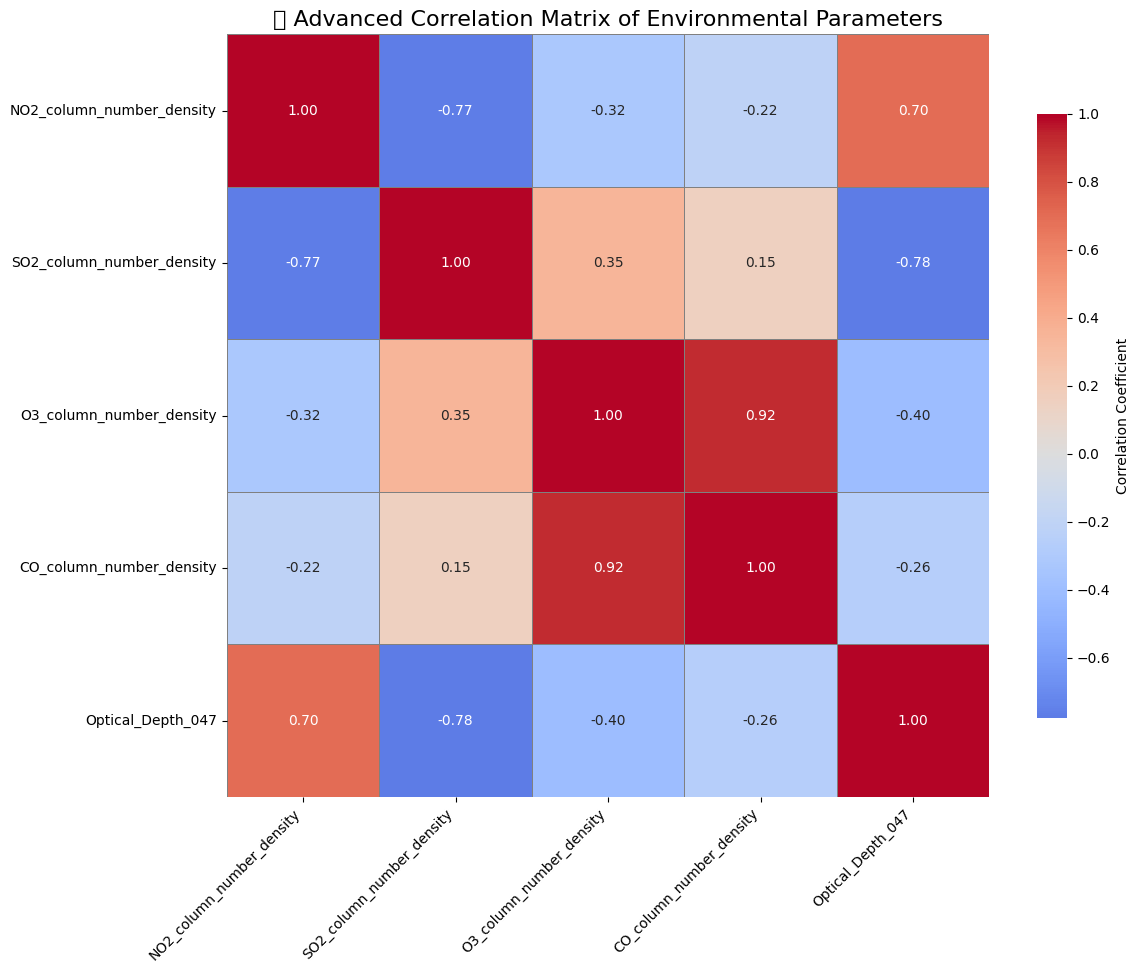

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the DataFrame: Drop non-numeric or NaN-heavy columns
df_corr = df.drop(columns=['month']).dropna()

# Compute correlation matrix
corr = df_corr.corr()

# Advanced heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='grey', square=True,
            cbar_kws={"shrink": 0.75, 'label': 'Correlation Coefficient'})

plt.title('ðŸ”— Advanced Correlation Matrix of Environmental Parameters', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('advanced_correlation_matrix.png', dpi=300)
plt.show()


In [12]:
# Cell 11: Spatial Map Example (NO2)
try:
    # Debug: Check available months
    months = no2_monthly.aggregate_array('month').getInfo()
    print(f"Available months in no2_monthly: {months}")
    
    # Try April 2020 with correct format
    no2_sample = no2_monthly.filter(ee.Filter.eq('month', '2020-04')).first()
    if no2_sample is None:
        print("Warning: No image found for April 2020. Trying January 2020...")
        no2_sample = no2_monthly.filter(ee.Filter.eq('month', '2020-01')).first()
    if no2_sample is None:
        print("Error: No valid NO2 image found. Skipping map generation.")
    else:
        Map = geemap.Map()
        Map.addLayer(no2_sample, {'min': 0, 'max': 0.0001, 'palette': ['blue', 'green', 'yellow', 'red']}, 'NO2 April 2020')
        Map.centerObject(roi, 5)
        Map.to_html('no2_map.html')
        print("NO2 map generated successfully.")
except Exception as e:
    print(f"Error generating NO2 map: {e}")

Available months in no2_monthly: ['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09']
NO2 map generated successfully.


In [13]:
# Cell 12: Preprocessing - Handle Missing Data and Simulate Ground Truth
df = df.fillna(df.mean())
np.random.seed(42)
df['fine_NO2'] = df['NO2_column_number_density'] * 1e6 + np.random.normal(0, 0.01, len(df))
df['fine_SO2'] = df['SO2_column_number_density'] * 1e6 + np.random.normal(0, 0.01, len(df))
df['fine_O3'] = df['O3_column_number_density'] * 1e3 + np.random.normal(0, 0.01, len(df))
df['fine_CO'] = df['CO_column_number_density'] * 1e3 + np.random.normal(0, 0.01, len(df))
df['fine_AOD'] = df['Optical_Depth_047'] + np.random.normal(0, 0.01, len(df))


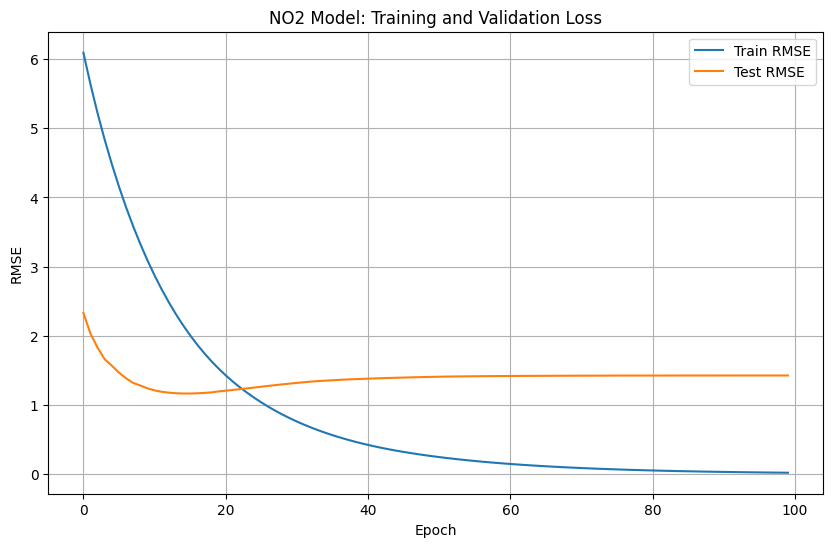

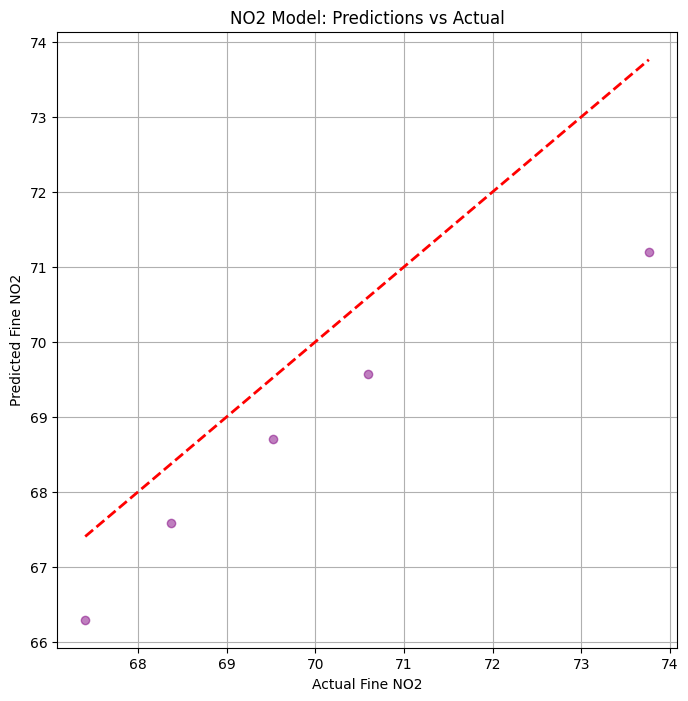

NO2 Model - Test RMSE: 1.4257, MAE: 1.2610


In [14]:
# Cell 13: Training - NO2 Model
features = ['NO2_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_NO2']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_no2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_no2.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_no2 = xgb_no2.evals_result()
with open('model_no2.pkl', 'wb') as f:
    pickle.dump(xgb_no2, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_no2['validation_0']['rmse'])), results_no2['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_no2['validation_1']['rmse'])), results_no2['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('NO2 Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('no2_training_loss.png')
plt.show()
y_pred_no2 = xgb_no2.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_no2, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine NO2')
plt.ylabel('Predicted Fine NO2')
plt.title('NO2 Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('no2_predictions_vs_actual.png')
plt.show()
rmse_no2 = np.sqrt(mean_squared_error(y_test, y_pred_no2))
mae_no2 = mean_absolute_error(y_test, y_pred_no2)
print(f"NO2 Model - Test RMSE: {rmse_no2:.4f}, MAE: {mae_no2:.4f}")


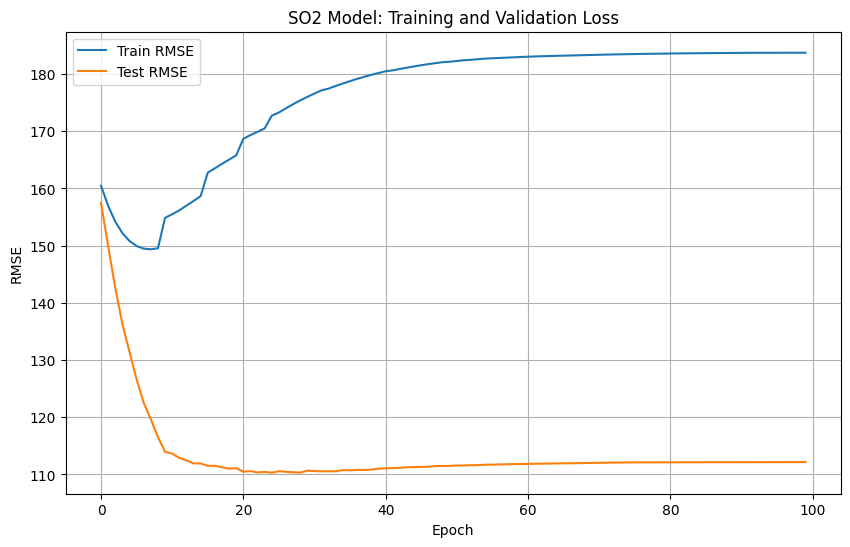

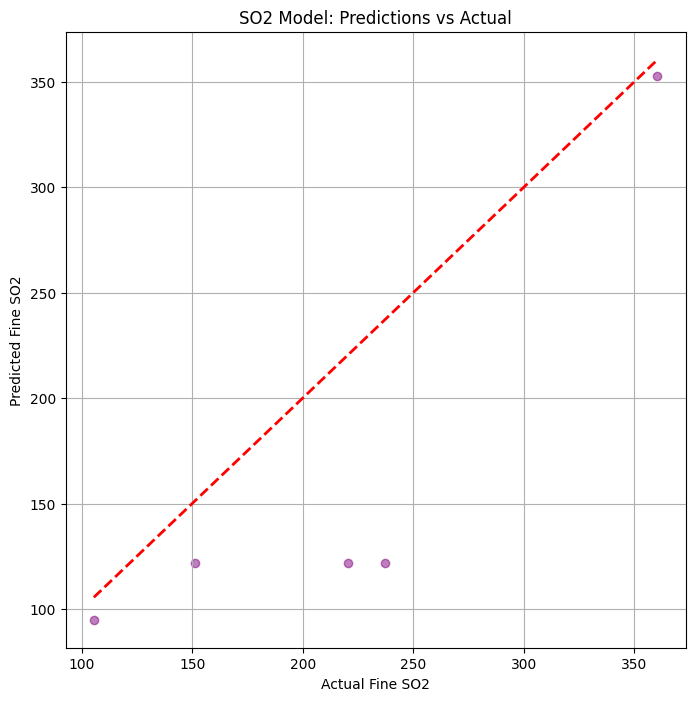

SO2 Model - Test RMSE: 69.2400, MAE: 52.2633


In [15]:
# Cell 14: Training - SO2 Model
features = ['SO2_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_SO2']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_so2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_so2.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_so2 = xgb_so2.evals_result()
with open('model_so2.pkl', 'wb') as f:
    pickle.dump(xgb_so2, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_so2['validation_0']['rmse'])), results_so2['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_so2['validation_1']['rmse'])), results_so2['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('SO2 Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('so2_training_loss.png')
plt.show()
y_pred_so2 = xgb_so2.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_so2, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine SO2')
plt.ylabel('Predicted Fine SO2')
plt.title('SO2 Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('so2_predictions_vs_actual.png')
plt.show()
rmse_so2 = np.sqrt(mean_squared_error(y_test, y_pred_so2))
mae_so2 = mean_absolute_error(y_test, y_pred_so2)
print(f"SO2 Model - Test RMSE: {rmse_so2:.4f}, MAE: {mae_so2:.4f}")

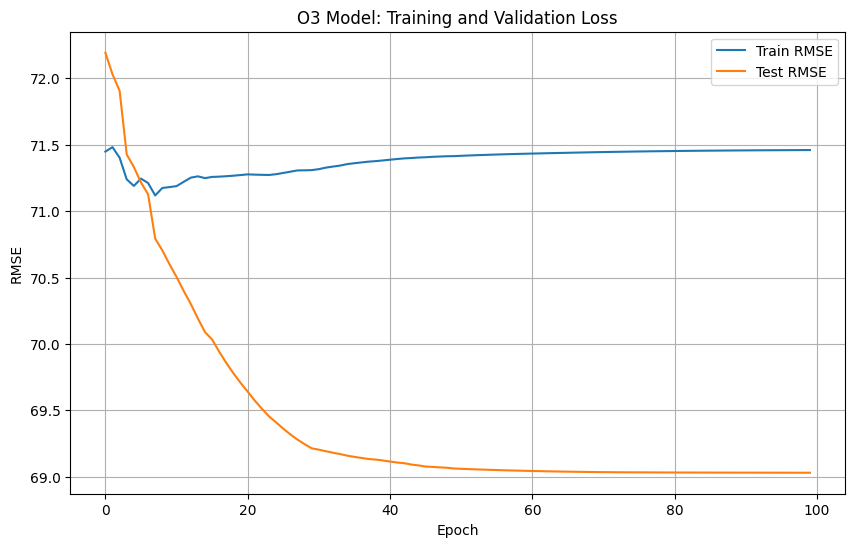

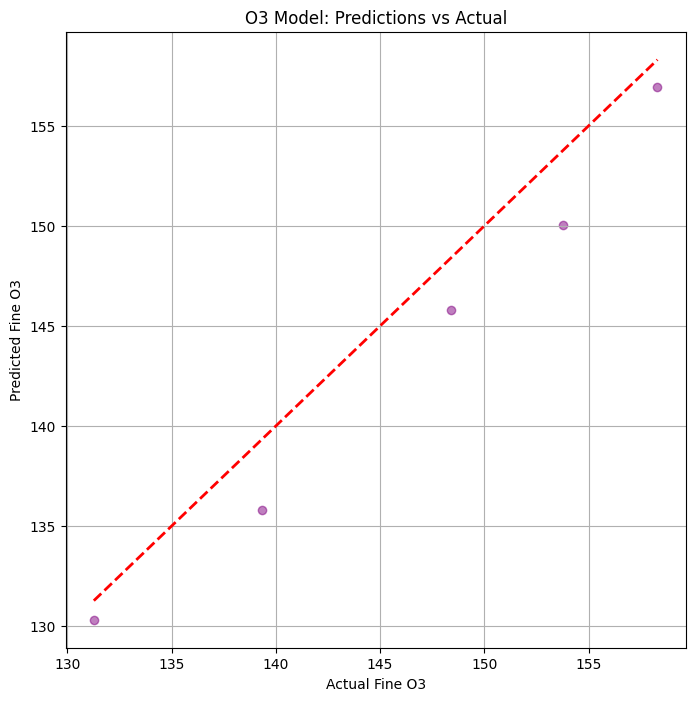

O3 Model - Test RMSE: 2.6931, MAE: 2.4459


In [16]:
# Cell 15: Training - O3 Model
features = ['O3_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_O3']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_o3 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_o3.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_o3 = xgb_o3.evals_result()
with open('model_o3.pkl', 'wb') as f:
    pickle.dump(xgb_o3, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_o3['validation_0']['rmse'])), results_o3['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_o3['validation_1']['rmse'])), results_o3['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('O3 Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('o3_training_loss.png')
plt.show()
y_pred_o3 = xgb_o3.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_o3, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine O3')
plt.ylabel('Predicted Fine O3')
plt.title('O3 Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('o3_predictions_vs_actual.png')
plt.show()
rmse_o3 = np.sqrt(mean_squared_error(y_test, y_pred_o3))
mae_o3 = mean_absolute_error(y_test, y_pred_o3)
print(f"O3 Model - Test RMSE: {rmse_o3:.4f}, MAE: {mae_o3:.4f}")

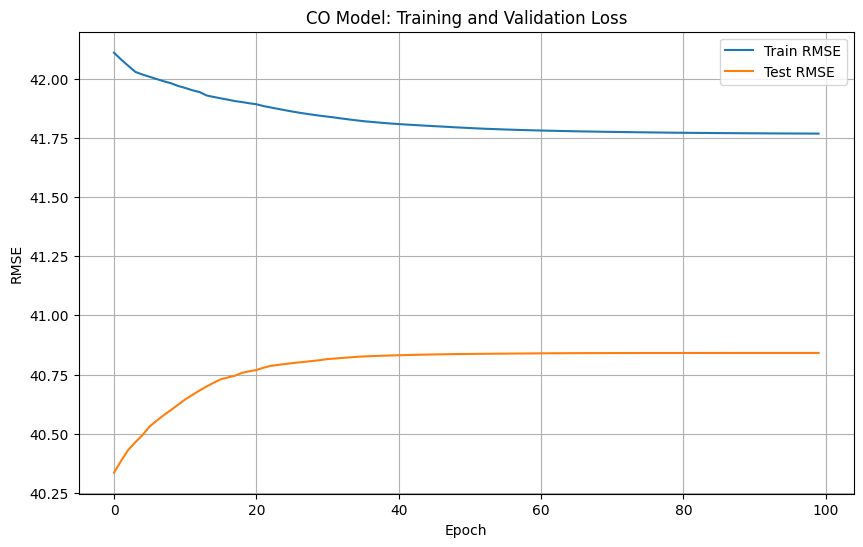

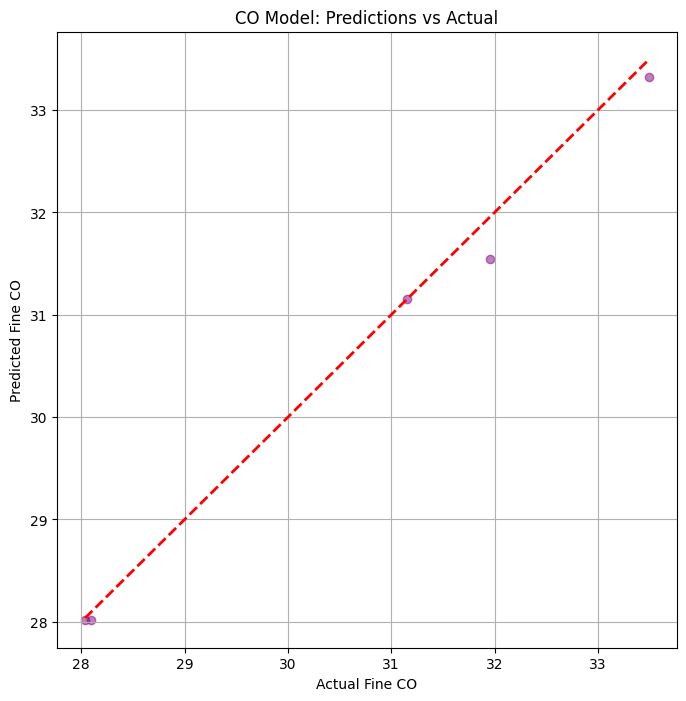

CO Model - Test RMSE: 0.1986, MAE: 0.1332


In [17]:
# Cell 16: Training - CO Model
features = ['CO_column_number_density', 'Optical_Depth_047']
X = df[features]
y = df['fine_CO']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_co = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_co.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_co = xgb_co.evals_result()
with open('model_co.pkl', 'wb') as f:
    pickle.dump(xgb_co, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_co['validation_0']['rmse'])), results_co['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_co['validation_1']['rmse'])), results_co['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('CO Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('co_training_loss.png')
plt.show()
y_pred_co = xgb_co.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_co, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine CO')
plt.ylabel('Predicted Fine CO')
plt.title('CO Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('co_predictions_vs_actual.png')
plt.show()
rmse_co = np.sqrt(mean_squared_error(y_test, y_pred_co))
mae_co = mean_absolute_error(y_test, y_pred_co)
print(f"CO Model - Test RMSE: {rmse_co:.4f}, MAE: {mae_co:.4f}")

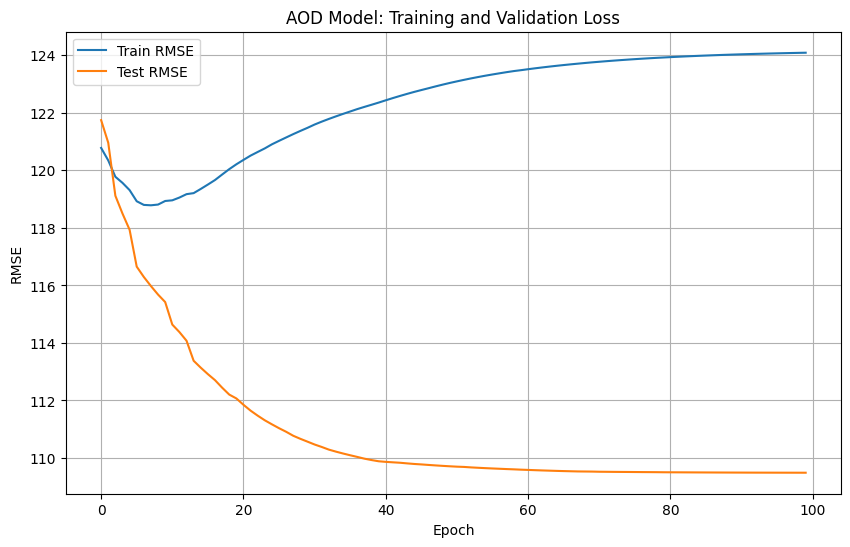

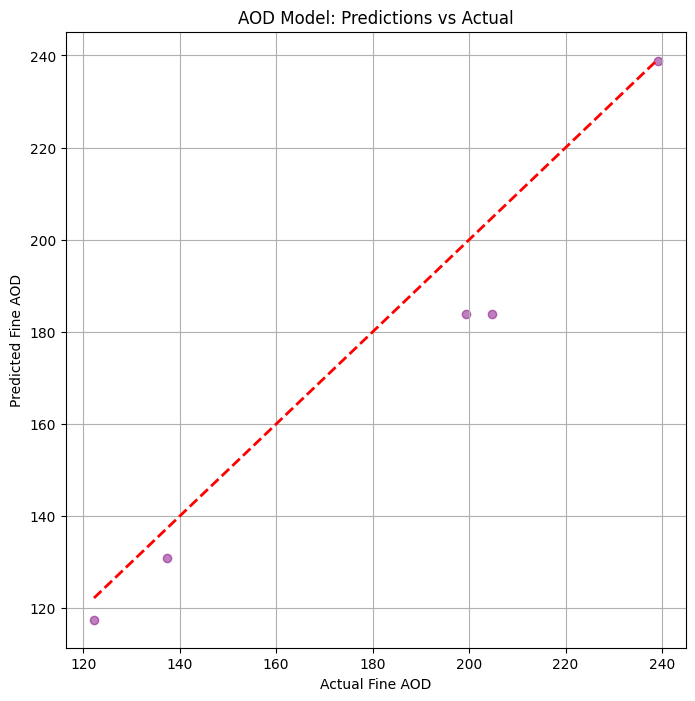

AOD Model - Test RMSE: 12.1446, MAE: 9.5565


In [18]:
# Cell 17: Training - AOD Model
features = ['Optical_Depth_047', 'NO2_column_number_density']
X = df[features]
y = df['fine_AOD']
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
xgb_aod = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, eval_metric='rmse', random_state=42)
xgb_aod.fit(X_train, y_train, eval_set=eval_set, verbose=False)
results_aod = xgb_aod.evals_result()
with open('model_aod.pkl', 'wb') as f:
    pickle.dump(xgb_aod, f)
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_aod['validation_0']['rmse'])), results_aod['validation_0']['rmse'], label='Train RMSE')
plt.plot(range(len(results_aod['validation_1']['rmse'])), results_aod['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('AOD Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('aod_training_loss.png')
plt.show()
y_pred_aod = xgb_aod.predict(X_test)
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_aod, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fine AOD')
plt.ylabel('Predicted Fine AOD')
plt.title('AOD Model: Predictions vs Actual')
plt.grid(True)
plt.savefig('aod_predictions_vs_actual.png')
plt.show()
rmse_aod = np.sqrt(mean_squared_error(y_test, y_pred_aod))
mae_aod = mean_absolute_error(y_test, y_pred_aod)
print(f"AOD Model - Test RMSE: {rmse_aod:.4f}, MAE: {mae_aod:.4f}")

<Figure size 1000x600 with 0 Axes>

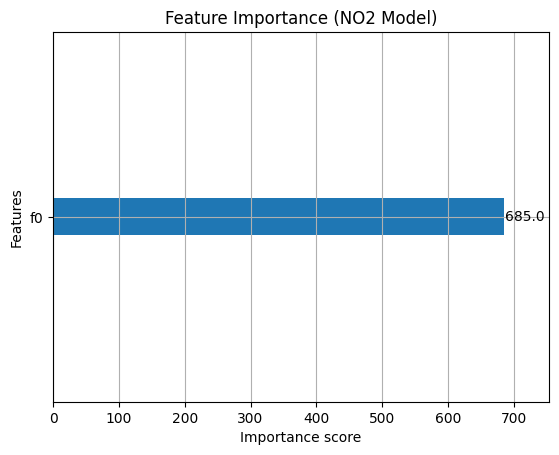

In [19]:
# Cell 18: Feature Importance (NO2 Model)
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_no2, max_num_features=5)
plt.title('Feature Importance (NO2 Model)')
plt.savefig('feature_importance_no2.png')
plt.show()

In [20]:
# Import required libraries
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import os

# Define paths
data_path = r'C:\Users\muhda\Downloads\final-pp\gee_data.pkl'
output_dir = r'C:\Users\muhda\Downloads\final-pp'

# Define feature sets for each pollutant (same as in app.py)
feature_sets = {
    'NO2': ['NO2_column_number_density', 'Optical_Depth_047'],
    'SO2': ['SO2_column_number_density', 'Optical_Depth_047'],
    'O3': ['O3_column_number_density', 'Optical_Depth_047'],
    'CO': ['CO_column_number_density', 'Optical_Depth_047'],
    'AOD': ['Optical_Depth_047', 'NO2_column_number_density']
}

# Check if gee_data.pkl exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"gee_data.pkl not found at {data_path}. Please ensure the file exists.")

# Load gee_data.pkl
print("Loading gee_data.pkl...")
data = pd.read_pickle(data_path)
print("Columns in gee_data.pkl:", data.columns.tolist())

# Verify required columns
required_columns = set()
for features in feature_sets.values():
    required_columns.update(features)
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"Missing required columns in gee_data.pkl: {missing_columns}")

# Generate and save scalers
scalers = {}
for pollutant, features in feature_sets.items():
    print(f"\nGenerating scaler for {pollutant}...")
    # Select feature data
    X = data[features].copy()
    
    # Handle missing values (fill with mean)
    X.fillna(X.mean(), inplace=True)
    
    # Initialize and fit scaler
    scaler = StandardScaler()
    scaler.fit(X)
    scalers[pollutant] = scaler
    
    # Save scaler to .pkl file
    output_path = os.path.join(output_dir, f'scaler_{pollutant.lower()}.pkl')
    with open(output_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Saved {output_path}")

print("\nAll scalers generated successfully!")
print("Files created:", [f'scaler_{pollutant.lower()}.pkl' for pollutant in feature_sets.keys()])

Loading gee_data.pkl...
Columns in gee_data.pkl: ['month', 'NO2_column_number_density', 'SO2_column_number_density', 'O3_column_number_density', 'CO_column_number_density', 'Optical_Depth_047']

Generating scaler for NO2...
Saved C:\Users\muhda\Downloads\final-pp\scaler_no2.pkl

Generating scaler for SO2...
Saved C:\Users\muhda\Downloads\final-pp\scaler_so2.pkl

Generating scaler for O3...
Saved C:\Users\muhda\Downloads\final-pp\scaler_o3.pkl

Generating scaler for CO...
Saved C:\Users\muhda\Downloads\final-pp\scaler_co.pkl

Generating scaler for AOD...
Saved C:\Users\muhda\Downloads\final-pp\scaler_aod.pkl

All scalers generated successfully!
Files created: ['scaler_no2.pkl', 'scaler_so2.pkl', 'scaler_o3.pkl', 'scaler_co.pkl', 'scaler_aod.pkl']
